# GP-ConvCNP Examples

This notebook will allow you to explore our proposed GP-ConvCNP as well as all the baselines. You will need to install the `neuralprocess` package contained within the ZIP file you received. For instructions on how to do that, please consult the `README.md`.

Below, we will first construct data generators that produce functions like the ones used in the paper. We then load pretrained models and visualize predictions similar to the figures found in our paper. The last section offers an interactive example, where you can manually place context points. This is a good way to explore edge cases.

**IMPORTANT: We experienced some weird behaviour going from %matplotlib inline (what the random examples use) to %matplotlib notebook (what the interactive example uses). If the interactive example doesn't work, rerun the cell or restart the kernel and skip the random example!**

We will use the following abbreviations for the different function families:

* `matern` for samples from a Gaussian Process with a Matern-5/2 kernel
* `wp` for samples from a Gaussian Process with a weakly periodic kernel
* `fourier` for randomly constructed Fourier series
* `step` for step function samples
* `lotka` for Lotka-Volterra based population dynamics
* `temperature` for temperature time series

## Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import ipywidgets as widgets
from IPython.display import display
from matplotlib import lines as mlines
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)

import neuralprocess
from neuralprocess.data import (
    GaussianProcessGenerator,
    StepFunctionGenerator,
    FourierSeriesGenerator,
    gp,
    LotkaVolterraGenerator,
    TemperatureGenerator
)
from neuralprocess.model import pretrained
from neuralprocess import util

## Data Generators

These generators are constructed to match what the models were trained on, except num_context and num_target, which are fixed. We choose num_context small enough to still allow for significant variation in the samples. Feel free to change parameters to see how well the methods handle those changes.

In [2]:
base_kwargs = dict(
    batch_size=1,
    num_target=200,
    output_noise=0.,
    linspace=True
)

generators = {
    "matern": GaussianProcessGenerator(
        **base_kwargs,
        x_range=(-3, 3),
        num_context=15,
        kernel_type=gp.Matern52Kernel,
        kernel_kwargs=dict(lengthscale=0.5)
    ),
    "wp": GaussianProcessGenerator(
        **base_kwargs,
        x_range=(-3, 3),
        num_context=20,
        kernel_type=gp.WeaklyPeriodicKernel,
        kernel_kwargs=dict()
    ),
    "fourier": FourierSeriesGenerator(
        **base_kwargs,
        x_range=(-3, 3),
        num_context=20,
        series_length=(10, 20),
        amplitude=(-1, 1),
        phase=(-1, 1),
        bias=(-1, 1),
        frequency_scale=1.0
    ),
    "step": StepFunctionGenerator(
        **base_kwargs,
        x_range=(-3, 3),
        num_context=20,
        y_range=(-3, 3),
        number_of_steps=(3, 10),
        min_step_width=0.1,
        min_step_height=0.1
    ),
    "lotka": LotkaVolterraGenerator(
        **base_kwargs,
        num_context=20,
        predator_init=(50, 100),
        prey_init=(100, 150),
        rate0=(0.005, 0.01),
        rate1=(0.5, 0.8),
        rate2=(0.5, 0.8),
        rate3=(0.005, 0.01),
        sequence_length=10000,
        y_rescale=0.01,
        x_rescale=0.1,
        max_time=100.0,
        max_population=500,
        super_sample=1.5,
    ),
    "temperature": TemperatureGenerator(
        **base_kwargs,
        x_range=(0, 3),
        num_context=50,
        sequence_length=30*24
    )
}

## Pretrained Models

The models are very small (NP ~1.3MB, ANP ~2.1MB, ConvCNP & GP-ConvCNP ~207kB), so we can load them all at once.

In [3]:
NP_models = {}
ANP_models = {}
ConvCNP_models = {}
GPConvCNP_models = {}

for function_type in ("matern", "wp", "step", "fourier", "lotka", "temperature"):
    NP_models[function_type] = pretrained.NeuralProcess(function_type).eval()
    ANP_models[function_type] = pretrained.AttentiveNeuralProcess(function_type).eval()
    ConvCNP_models[function_type] = pretrained.ConvCNP(function_type, use_gp=False).eval()
    GPConvCNP_models[function_type] = pretrained.ConvCNP(function_type, use_gp=True).eval()

## Synthetic Examples

With the following cell you can generate random examples for the different function types, like the ones seen in the supplementary material of our submission (and similar to the ones in the main text). At the top of the cell are a number of configuration options:

* `function_type` selects which function generator and models are used.
* `num_samples` is the number of samples we draw from a method for a given example
* `x_range` defines the x range. If you choose something wider than (-3, 3), you can see how well the methods generalize.

/home/jens/anaconda3/lib/python3.6/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
/home/jens/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/jens/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


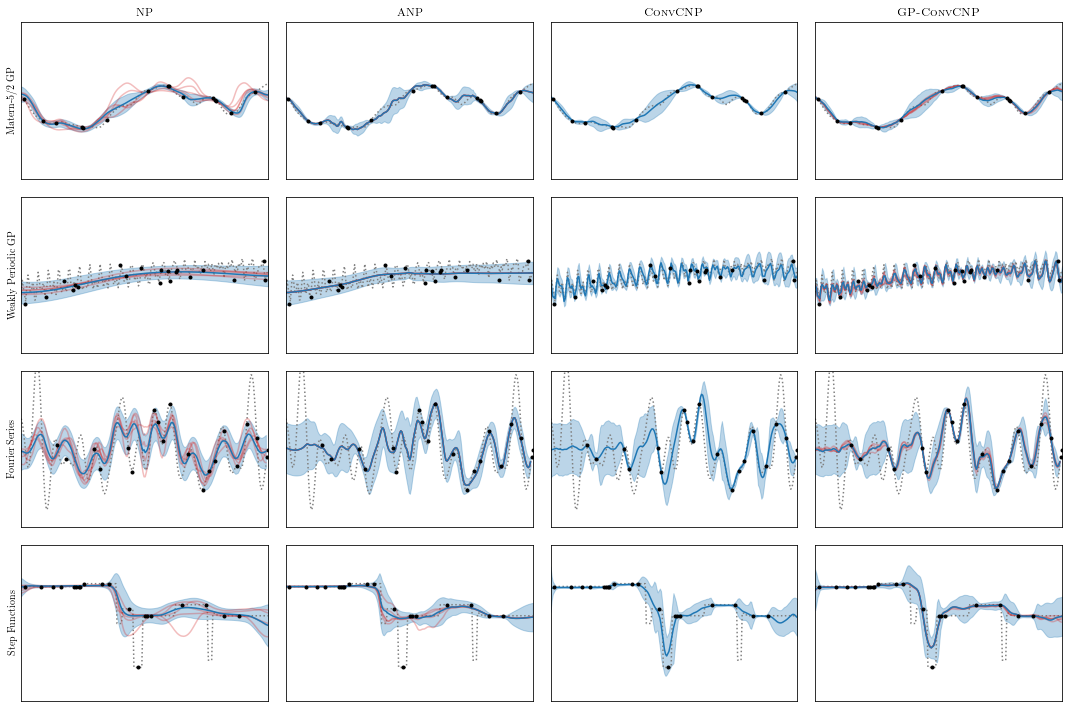

In [4]:
function_type = "step"  # you can change this to "wp" o"step"
num_samples = 5  # number of samples for each example
show_ticks = False  # You can use this to toggle axis ticks
prediction_color = cm.tab10(0)
sample_color = cm.tab10(3)
y_range = (-5, 5)

prediction_color = cm.tab10(0)
sample_color = cm.tab10(3)
y_labels = {
    "matern": "Matern-5/2 GP",
    "wp": "Weakly Periodic GP",
    "fourier": "Fourier Series",
    "step": "Step Functions"
}

%matplotlib inline
fig, ax = plt.subplots(4, 4, figsize=(15, 10))

for r, func in enumerate(y_labels.keys()):
    
    batch = next(generators[func])
    
    for m, model in enumerate((NP_models[func], ANP_models[func], ConvCNP_models[func], GPConvCNP_models[func])):
        with torch.no_grad():
            
            ax[r, m].set_xlim(*generators[func].x_range)
            ax[r, m].set_ylim(*y_range)
            
            prediction = model(batch["context_in"], batch["context_out"], batch["target_in"], store_rep=True)
            prediction = util.tensor_to_loc_scale(prediction, torch.distributions.Normal, axis=2)
            
            ax[r, m].fill_between(
                batch["target_in"][0, :, 0],
                prediction.loc[0, :, 0] - prediction.scale[0, :, 0],
                prediction.loc[0, :, 0] + prediction.scale[0, :, 0],
                color=prediction_color,
                alpha=0.3
            )
            ax[r, m].plot(
                batch["target_in"][0, :, 0],
                batch["target_out"][0, :, 0],
                c="grey",
                linestyle=":"
            )
            if m != 2:
                samples = model.sample(batch["target_in"], num_samples)
                samples = util.tensor_to_loc_scale(samples, torch.distributions.Normal, axis=3)
                ax[r, m].plot(batch["target_in"][0, :], samples.loc[:, 0, :, 0].T, c=sample_color, alpha=0.3)
            ax[r, m].plot(batch["target_in"][0, :, 0], prediction.loc[0, :, 0], c=prediction_color)
            ax[r, m].plot(
                batch["context_in"][0, :, 0],
                batch["context_out"][0, :, 0],
                c="black",
                marker="o",
                ms=3,
                linewidth=0
            )
                
            if not show_ticks:
                ax[r, m].set_xticks([])
                ax[r, m].set_yticks([])
                
    ax[r, 0].set_ylabel(y_labels[func])
            
ax[0, 0].set_title("NP")
ax[0, 1].set_title("ANP")
ax[0, 2].set_title(r"\textsc{ConvCNP}")
ax[0, 3].set_title(r"\textsc{GP-ConvCNP}")
        
fig.tight_layout()
plt.show()

## Temperature Time Series

Produce figures similar to figure 2 from our submission. There are some configuration options at the top

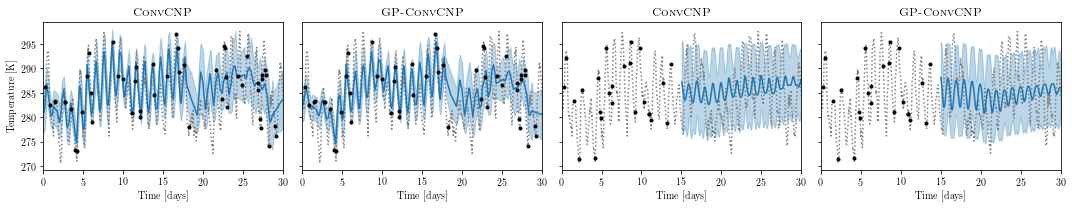

In [37]:
%matplotlib inline

convcnp = True  # if True, will show ConvCNP and GP-ConvCNP, otherwise NP and ANP
prediction_color = cm.tab10(0)
rows = 1  # each row is one example

fig, ax = plt.subplots(rows, 4, figsize=(15, 3*rows), sharey=True)
if ax.ndim == 1:
    ax = ax[None, :]

gen = generators["temperature"]
x_norm = gen.sequence_length / (gen.x_range[1] - gen.x_range[0]) / 24  # days
        
for r in range(rows):
    
    if convcnp:
        models = (ConvCNP_models["temperature"], GPConvCNP_models["temperature"])
    else:
        models = (NP_models["temperature"], ANP_models["temperature"])
        
    batch = next(gen)
    city = batch["cities"][0]
    
    # INTERPOLATION
    
    for m, model in enumerate(models):
        with torch.no_grad():
            
            prediction = model(batch["context_in"], batch["context_out"], batch["target_in"], store_rep=True)
            prediction = util.tensor_to_loc_scale(prediction, torch.distributions.Normal, axis=2)
            prediction.loc = prediction.loc * gen.std_temp[city] + gen.mean_temp[city]
            prediction.scale = prediction.scale * gen.std_temp[city]
            
            ax[r, m].fill_between(
                batch["target_in"][0, :, 0] * x_norm,
                prediction.loc[0, :, 0] - prediction.scale[0, :, 0],
                prediction.loc[0, :, 0] + prediction.scale[0, :, 0],
                color=prediction_color,
                alpha=0.3
            )
            ax[r, m].plot(
                batch["x"][0, :, 0] * x_norm,
                batch["y"][0, :, 0] * gen.std_temp[city] + gen.mean_temp[city],
                c="grey",
                linestyle=":"
            )
            ax[r, m].plot(
                batch["target_in"][0, :, 0] * x_norm,
                prediction.loc[0, :, 0],
                c=prediction_color
            )
            ax[r, m].plot(
                batch["context_in"][0, :, 0] * x_norm,
                batch["context_out"][0, :, 0] * gen.std_temp[city] + gen.mean_temp[city],
                c="black",
                marker="o",
                ms=3,
                linewidth=0
            )
            
    # EXTRAPOLATION
            
    x = batch["x"]
    y = batch["y"]

    x_context = batch["x"][:, :x.shape[1] // 2]
    y_context = batch["y"][:, :y.shape[1] // 2]

    num_context = batch["context_in"].shape[1] // 2
    context_indices = np.random.choice(np.arange(x_context.shape[1]), num_context, replace=False)
    context_indices.sort()

    batch["context_in"] = torch.from_numpy(x_context[:, context_indices]).float()
    batch["context_out"] = torch.from_numpy(y_context[:, context_indices]).float()
    batch["target_in"] = torch.from_numpy(batch["x"][:, x.shape[1] // 2:]).float()
    batch["target_out"] = torch.from_numpy(batch["y"][:, x.shape[1] // 2:]).float()
    
    for m, model in enumerate(models):
        with torch.no_grad():
            
            prediction = model(batch["context_in"], batch["context_out"], batch["target_in"], store_rep=True)
            prediction = util.tensor_to_loc_scale(prediction, torch.distributions.Normal, axis=2)
            prediction.loc = prediction.loc * gen.std_temp[city] + gen.mean_temp[city]
            prediction.scale = prediction.scale * gen.std_temp[city]
            
            ax[r, m + 2].fill_between(
                batch["target_in"][0, :, 0] * x_norm,
                prediction.loc[0, :, 0] - prediction.scale[0, :, 0],
                prediction.loc[0, :, 0] + prediction.scale[0, :, 0],
                color=prediction_color,
                alpha=0.3
            )
            ax[r, m + 2].plot(
                batch["x"][0, :, 0] * x_norm,
                batch["y"][0, :, 0] * gen.std_temp[city] + gen.mean_temp[city],
                c="grey",
                linestyle=":"
            )
            ax[r, m + 2].plot(
                batch["target_in"][0, :, 0] * x_norm,
                prediction.loc[0, :, 0],
                c=prediction_color
            )
            ax[r, m + 2].plot(
                batch["context_in"][0, :, 0] * x_norm,
                batch["context_out"][0, :, 0] * gen.std_temp[city] + gen.mean_temp[city],
                c="black",
                marker="o",
                ms=3,
                linewidth=0
            )
            
            ax[r, m].set_xlim(0, 3 * x_norm)
            ax[r, m + 2].set_xlim(0, 3 * x_norm)
            
    ax[r, 0].set_ylabel("Temperature [K]")
            
if convcnp:
    ax[0, 0].set_title(r"\textsc{ConvCNP}")
    ax[0, 2].set_title(r"\textsc{ConvCNP}")
    ax[0, 1].set_title(r"\textsc{GP-ConvCNP}")
    ax[0, 3].set_title(r"\textsc{GP-ConvCNP}")
else:
    ax[0, 0].set_title("NP")
    ax[0, 2].set_title("NP")
    ax[0, 1].set_title("ANP")
    ax[0, 3].set_title("ANP")
for i in range(4):
    ax[-1, i].set_xlabel("Time [days]")
        
fig.tight_layout()
plt.show()

## Population Dynamics

Produce figures similar to figure 3 from our submission. There are some configuration options at the top. The real data has a different range than the simulated data, so we normalize the real data to have the same mean population and mean duration as the simulated data.

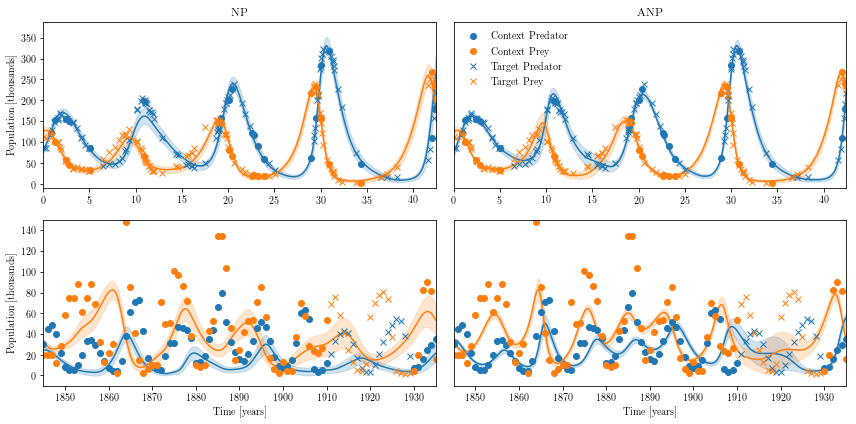

In [19]:
%matplotlib inline

convcnp = False  # if True, will show ConvCNP and GP-ConvCNP, otherwise NP and ANP
predator_color = cm.tab10(0)
prey_color = cm.tab10(1)
markersize = 6
target_marker = "x"

gen = generators["lotka"]
gen.num_target = 100
if convcnp:
    models = (ConvCNP_models["lotka"], GPConvCNP_models["lotka"])
else:
    models = (NP_models["lotka"], ANP_models["lotka"])

# simulated data first
data_sim = next(gen)
target_in_sim = torch.linspace(data_sim["target_in"].min(), data_sim["target_in"].max(), 500)[None, :, None]
predictions_loc_sim = []
predictions_scale_sim = []
samples_sim = []
for model in models:
    with torch.no_grad():
        prediction = model(data_sim["context_in"], data_sim["context_out"], target_in_sim)
        prediction = util.tensor_to_loc_scale(prediction, torch.distributions.Normal, axis=2)
        predictions_loc_sim.append(prediction.loc)
        predictions_scale_sim.append(prediction.scale)

# now real data
data_real = neuralprocess.data.get_lynx_hare_data()
norm_population = 0.032  # so that simulated and real data have the same mean populations
norm_years = 4.337  # so that simulated and real data have the same mean duration
test_interval_start = 66
test_interval_length = 18

min_year = data_real.values[0, 0]
max_year = data_real.values[-1, 0]
years = norm_years * (data_real.values[:, 0:1] - min_year) / (max_year - min_year)
population = norm_population * data_real.values[:, 1:]
test_interval = (test_interval_start, test_interval_start + test_interval_length + 1)
                        
context_in_real = torch.from_numpy(
    np.concatenate((
        years[:test_interval[0], :],
        years[test_interval[1]:, :]
    ), 0)[None, ...]
).float()
context_out_real = torch.from_numpy(
    np.concatenate((
        population[:test_interval[0], :],
        population[test_interval[1]:, :]
    ), 0)[None, ...]
).float()
target_in_real = torch.linspace(0, norm_years, 500)[None, :, None]

predictions_loc_real = []
predictions_scale_real = []
samples_real = []
for model in models:
    with torch.no_grad():
        prediction = model(context_in_real, context_out_real, target_in_real)
        prediction = util.tensor_to_loc_scale(prediction, torch.distributions.Normal, axis=2)
        predictions_loc_real.append(prediction.loc)
        predictions_scale_real.append(prediction.scale)

fig, ax = plt.subplots(2, 2, figsize=(12, 6))

for m, model in enumerate(models):
    
    ax[0, m].set_xlim(0, data_sim["target_in"].max().item() / gen.x_rescale)
    ax[0, m].set_ylim(-10, 1.2 * data_sim["target_out"].max() / gen.y_rescale)
    ax[1, m].set_xlim(min_year, max_year)
    ax[1, m].set_ylim(-10, 150)
    if m > 0:
        ax[0, m].set_yticks([])
        ax[1, m].set_yticks([])
    ax[1, m].set_xlabel("Time [years]")
    if m == 0:
        ax[0, 0].set_ylabel("Population [thousands]")
        ax[1, 0].set_ylabel("Population [thousands]")

    # simulated
    ax[0, m].fill_between(
        target_in_sim[0, :, 0] / gen.x_rescale,
        (predictions_loc_sim[m][0, :, 0] - predictions_scale_sim[m][0, :, 0]) / gen.y_rescale,
        (predictions_loc_sim[m][0, :, 0] + predictions_scale_sim[m][0, :, 0]) / gen.y_rescale,
        color=predator_color,
        alpha=0.2
    )
    ax[0, m].fill_between(
        target_in_sim[0, :, 0] / gen.x_rescale,
        (predictions_loc_sim[m][0, :, 1] - predictions_scale_sim[m][0, :, 1]) / gen.y_rescale,
        (predictions_loc_sim[m][0, :, 1] + predictions_scale_sim[m][0, :, 1]) / gen.y_rescale,
        color=prey_color,
        alpha=0.2
    )
    ax[0, m].plot(
        target_in_sim[0, :, 0] / gen.x_rescale,
        predictions_loc_sim[m][0, :, 0] / gen.y_rescale,
        c=predator_color
    )
    ax[0, m].plot(
        target_in_sim[0, :, 0] / gen.x_rescale,
        predictions_loc_sim[m][0, :, 1] / gen.y_rescale,
        c=prey_color
    )
    ax[0, m].plot(
        data_sim["context_in"][0] / gen.x_rescale,
        data_sim["context_out"][0, :, 0:1] / gen.y_rescale,
        linewidth=0,
        c=predator_color,
        marker="o",
        ms=markersize
    )
    ax[0, m].plot(
        data_sim["context_in"][0] / gen.x_rescale,
        data_sim["context_out"][0, :, 1:2] / gen.y_rescale,
        c=prey_color,
        linewidth=0,
        marker="o",
        ms=markersize
    )
    ax[0, m].plot(
        data_sim["target_in"][0] / gen.x_rescale,
        data_sim["target_out"][0, :, 0:1] / gen.y_rescale,
        linewidth=0,
        c=predator_color,
        marker=target_marker,
        fillstyle="none",
        ms=markersize
    )
    ax[0, m].plot(
        data_sim["target_in"][0] / gen.x_rescale,
        data_sim["target_out"][0, :, 1:2] / gen.y_rescale,
        c=prey_color,
        linewidth=0,
        marker=target_marker,
        fillstyle="none",
        ms=markersize
    )
    
    # real
    ax[1, m].fill_between(
        target_in_real[0, :, 0] * (max_year - min_year) / norm_years + min_year,
        (predictions_loc_real[m][0, :, 0] - predictions_scale_real[m][0, :, 0]) / norm_population,
        (predictions_loc_real[m][0, :, 0] + predictions_scale_real[m][0, :, 0]) / norm_population,
        color=predator_color,
        alpha=0.2
    )
    ax[1, m].fill_between(
        target_in_real[0, :, 0] * (max_year - min_year) / norm_years + min_year,
        (predictions_loc_real[m][0, :, 1] - predictions_scale_real[m][0, :, 1]) / norm_population,
        (predictions_loc_real[m][0, :, 1] + predictions_scale_real[m][0, :, 1]) / norm_population,
        color=prey_color,
        alpha=0.2
    )
    ax[1, m].plot(
        target_in_real[0, :, 0] * (max_year - min_year) / norm_years + min_year,
        predictions_loc_real[m][0, :, 0] / norm_population,
        c=predator_color
    )
    ax[1, m].plot(
        target_in_real[0, :, 0] * (max_year - min_year) / norm_years + min_year,
        predictions_loc_real[m][0, :, 1] / norm_population,
        c=prey_color
    )
    ax[1, m].plot(
        context_in_real[0] * (max_year - min_year) / norm_years + min_year,
        context_out_real[0, :, 0:1] / norm_population,
        linewidth=0,
        c=predator_color,
        marker="o",
        ms=markersize
    )
    ax[1, m].plot(
        context_in_real[0] * (max_year - min_year) / norm_years + min_year,
        context_out_real[0, :, 1:2] / norm_population,
        c=prey_color,
        linewidth=0,
        marker="o",
        ms=markersize
    )
    ax[1, m].plot(
        data_real.values[test_interval[0]:test_interval[1], 0],
        data_real.values[test_interval[0]:test_interval[1], 1],
        linewidth=0,
        c=predator_color,
        marker=target_marker,
        fillstyle="none",
        ms=markersize
    )
    ax[1, m].plot(
        data_real.values[test_interval[0]:test_interval[1], 0],
        data_real.values[test_interval[0]:test_interval[1], 2],
        linewidth=0,
        c=prey_color,
        marker=target_marker,
        fillstyle="none",
        ms=markersize
    )

context_handle_predator = mlines.Line2D([], [], c=predator_color, linewidth=0, marker="o", label="Context Predator")
context_handle_prey = mlines.Line2D([], [], c=prey_color, linewidth=0, marker="o", label="Context Prey")
target_handle_predator = mlines.Line2D([], [], c=predator_color, linewidth=0, marker=target_marker, label="Target Predator")
target_handle_prey = mlines.Line2D([], [], c=prey_color, linewidth=0, marker=target_marker, label="Target Prey")
ax[0, -1].legend(frameon=False, handles=[context_handle_predator, context_handle_prey, target_handle_predator, target_handle_prey])

if convcnp:
    ax[0, 0].set_title(r"\textsc{ConvCNP}")
    ax[0, 1].set_title(r"\textsc{GP-ConvCNP}")
else:
    ax[0, 0].set_title("NP")
    ax[0, 1].set_title("ANP")

fig.tight_layout()
plt.show()

## Interactive Example

The following interactive example gives you the opportunity to manually place context points and see how the different methods behave. There are checkboxes to activate each method individually as well as one to toggle display of the predictive uncertainty. A dropdown menu gives you the option to select on what kinds of functions the models should have been trained. This example is especially useful to explore corner cases and failure modes. It's easy to place context points in a way that makes them unlikely to come from a true sample, and the predictions will reflect that. The training range will be indicated by vertical lines, keep in mind that NP and ANP perform very poorly when points are placed outside of that range.

The top panel shows mean predictions and the bottom panel shows samples. The panels will be empty in the beginning, and you need to manually add points. You can remove points by clicking on them again. Note that only the top panel is interactive!

Checkbox(value=True, description='GP-ConvCNP')

Checkbox(value=False, description='ConvCNP')

Checkbox(value=False, description='ANP')

Checkbox(value=False, description='NP')

Checkbox(value=True, description='Show Sigma')

Dropdown(description='Type', options=('matern', 'wp', 'fourier', 'step'), value='matern')

<IPython.core.display.Javascript object>


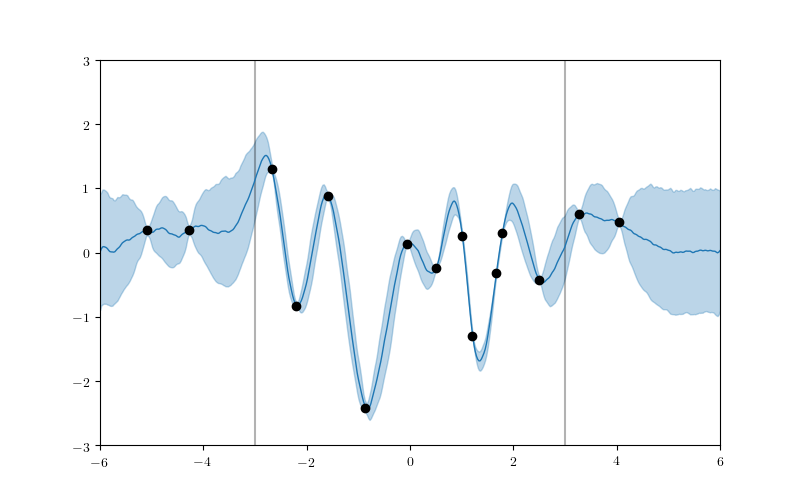

In [9]:
%matplotlib notebook

x_range = (-6, 6)
num_samples = 5

# Set up selectors
gpconvcnp_box = widgets.Checkbox(value=True, description="GP-ConvCNP")
convcnp_box = widgets.Checkbox(value=False, description="ConvCNP")
anp_box = widgets.Checkbox(value=False, description="ANP")
np_box = widgets.Checkbox(value=False, description="NP")
sigma_box = widgets.Checkbox(value=True, description="Show Sigma")
function_selector = widgets.Dropdown(
    options=["matern", "wp", "fourier", "step"],
    value="matern",
    description="Type"
)
display(gpconvcnp_box, convcnp_box, anp_box, np_box, sigma_box, function_selector)

class FigureBuilder:
    
    def __init__(self, ax):
        
        self.ax = ax

        self.sigma_handle_np = ax[0].fill_between([], [], [], color=cm.tab10(3), alpha=0.3)
        self.prediction_handle_np = ax[0].plot([], [], color=cm.tab10(3), linewidth=1)[0]
        self.sigma_handle_anp = ax[0].fill_between([], [], [], color=cm.tab10(2), alpha=0.3)
        self.prediction_handle_anp = ax[0].plot([], [], color=cm.tab10(2), linewidth=1)[0]
        self.sigma_handle_convcnp = ax[0].fill_between([], [], [], color=cm.tab10(1), alpha=0.3)
        self.prediction_handle_convcnp = ax[0].plot([], [], color=cm.tab10(1), linewidth=1)[0]
        self.sigma_handle_gpconvcnp = ax[0].fill_between([], [], [], color=cm.tab10(0), alpha=0.3)
        self.prediction_handle_gpconvcnp = ax[0].plot([], [], color=cm.tab10(0), linewidth=1)[0]
        
        self.context_handle_0 = ax[0].plot([], [], color="black", linewidth=0, marker="o", ms=6)[0]
        self.context_points = []
        self.cid = self.context_handle_0.figure.canvas.mpl_connect('button_press_event', self)
        
    def draw(self, *args, **kwargs):
        
        self.sigma_handle_np.get_paths().clear()
        self.sigma_handle_anp.get_paths().clear()
        self.sigma_handle_convcnp.get_paths().clear()
        self.sigma_handle_gpconvcnp.get_paths().clear()
        
        if len(self.context_points) > 0:
            
            # context points
            arr = np.array(self.context_points)
            self.context_handle_0.set_data(arr[:, 0], arr[:, 1])
            
            # prediction
            context_in = torch.from_numpy(arr[:, 0]).float().reshape(1, -1, 1)
            context_out = torch.from_numpy(arr[:, 1]).float().reshape(1, -1, 1)
            target_in = torch.linspace(*x_range, 500).reshape(1, -1, 1)
            
            with torch.no_grad():
                
                func = function_selector.value
                
                if gpconvcnp_box.value:
                    prediction = GPConvCNP_models[func](context_in, context_out, target_in, store_rep=True)
                    prediction = util.tensor_to_loc_scale(prediction, torch.distributions.Normal, axis=2)    
                    self.prediction_handle_gpconvcnp.set_data(target_in[0, :, 0], prediction.loc[0, :, 0])
                    if sigma_box.value:
                        self.sigma_handle_gpconvcnp = self.ax[0].fill_between(
                            target_in[0, :, 0],
                            prediction.loc[0, :, 0] - prediction.scale[0, :, 0],
                            prediction.loc[0, :, 0] + prediction.scale[0, :, 0],
                            color=cm.tab10(0),
                            alpha=0.3
                        )
                else:
                    self.prediction_handle_gpconvcnp.set_data([], [])
                    
                if convcnp_box.value:
                    prediction = ConvCNP_models[func](context_in, context_out, target_in)
                    prediction = util.tensor_to_loc_scale(prediction, torch.distributions.Normal, axis=2)    
                    self.prediction_handle_convcnp.set_data(target_in[0, :, 0], prediction.loc[0, :, 0])
                    if sigma_box.value:
                        self.sigma_handle_convcnp = self.ax[0].fill_between(
                            target_in[0, :, 0],
                            prediction.loc[0, :, 0] - prediction.scale[0, :, 0],
                            prediction.loc[0, :, 0] + prediction.scale[0, :, 0],
                            color=cm.tab10(1),
                            alpha=0.3
                        )
                else:
                    self.prediction_handle_convcnp.set_data([], [])
                    
                if anp_box.value:
                    prediction = ANP_models[func](context_in, context_out, target_in, store_rep=True)
                    prediction = util.tensor_to_loc_scale(prediction, torch.distributions.Normal, axis=2)    
                    self.prediction_handle_anp.set_data(target_in[0, :, 0], prediction.loc[0, :, 0])
                    if sigma_box.value:
                        self.sigma_handle_anp = self.ax[0].fill_between(
                            target_in[0, :, 0],
                            prediction.loc[0, :, 0] - prediction.scale[0, :, 0],
                            prediction.loc[0, :, 0] + prediction.scale[0, :, 0],
                            color=cm.tab10(2),
                            alpha=0.3
                        )
                else:
                    self.prediction_handle_anp.set_data([], [])

                if np_box.value:
                    prediction = NP_models[func](context_in, context_out, target_in, store_rep=True)
                    prediction = util.tensor_to_loc_scale(prediction, torch.distributions.Normal, axis=2)    
                    self.prediction_handle_np.set_data(target_in[0, :, 0], prediction.loc[0, :, 0])
                    if sigma_box.value:
                        self.sigma_handle_np = self.ax[0].fill_between(
                            target_in[0, :, 0],
                            prediction.loc[0, :, 0] - prediction.scale[0, :, 0],
                            prediction.loc[0, :, 0] + prediction.scale[0, :, 0],
                            color=cm.tab10(3),
                            alpha=0.3
                        )
                else:
                    self.prediction_handle_np.set_data([], [])
            
        else:
            
            self.context_handle_0.set_data([], [])
            self.prediction_handle_np.set_data([], [])
            self.prediction_handle_anp.set_data([], [])
            self.prediction_handle_convcnp.set_data([], [])
            self.prediction_handle_gpconvcnp.set_data([], [])
            
        self.context_handle_0.figure.canvas.draw()

    def __call__(self, event):
        
        if event.inaxes!=self.context_handle_0.axes:
            return
        
        x = event.xdata
        y = event.ydata
        
        for p, point in enumerate(self.context_points):
            dist = np.sqrt((point[0] - x)**2 + (point[1] - y)**2)
            if dist < 0.1:
                del self.context_points[p]
                break
        else:
            self.context_points.append((x, y))

        self.draw()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax = [ax, ]

ax[0].set_xlim(*x_range)
ax[0].set_ylim(-3, 3)
if x_range[0] < -3:
    ax[0].axvline(-3, c="black", alpha=0.3)
if x_range[1] > 3:
    ax[0].axvline(3, c="black", alpha=0.3)

figurebuilder = FigureBuilder(ax)

# Register widgets
for widget in (gpconvcnp_box, convcnp_box, anp_box, np_box, sigma_box, function_selector):
    widget.observe(figurebuilder.draw)

plt.show()